In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import TransformerMixin, FeatureUnion, make_pipeline, make_union, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
%matplotlib inline

In [2]:
trump_tweets = pd.read_csv('realdonaldtrump_tweets.csv')
clinton_tweets = pd.read_csv('hillaryclinton_tweets.csv')

trump_tweets["author"] = "Trump"
clinton_tweets["author"] = "Clinton"

tweets = pd.concat([trump_tweets, clinton_tweets])
tweets = tweets[[ u'id', u'text', u'created_at', u'favorite_count', u'retweet_count', u'author']]
tweets["id"] = tweets["id"].astype("str")
tweets = tweets.reset_index()
tweets = tweets.drop("index",1)
tweets.head()

,id,text,created_at,favorite_count,retweet_count,author
0,813079058896535552,"Merry Christmas and a very, very, very , very ...",Sun Dec 25 17:48:48 +0000 2016,156500.0,40939.0,Trump
1,813003030186622976,#MerryChristmas https://t.co/5GgDmJrGMS,Sun Dec 25 12:46:41 +0000 2016,123599.0,38682.0,Trump
2,812775995837218816,Happy #Hanukkah https://t.co/UvZwtykV1E,Sat Dec 24 21:44:32 +0000 2016,68085.0,19416.0,Trump
3,812773204561379330,The big loss yesterday for Israel in the Unite...,Sat Dec 24 21:33:27 +0000 2016,65890.0,16751.0,Trump
4,812764662500622336,.@NBCNews purposely left out this part of my n...,Sat Dec 24 20:59:30 +0000 2016,51140.0,14461.0,Trump


In [3]:
def percentInCaps(s):
    inCaps = sum(1 for c in s if c.isupper())
    inLowerCase = sum(1 for c in s if c.islower())
    return inCaps/float(inCaps + inLowerCase) 

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'

def manrt(s):
    return ((s[0] in ['"',"'"]) + (s[1] == '@') + (s[-1] in ['"',"'"]) == 3) + 0

    
tweets["percent_Punctuation"] = tweets["text"].apply(lambda x: sum(1 for c in x if c in punctuation)/float(len(x)))
tweets['num_!'] = tweets["text"].apply(lambda x: sum(1 for c in x if c == "!")/float(len(x)))
tweets['num_?'] = tweets["text"].apply(lambda x: sum(1 for c in x if c == "?")/float(len(x)))
tweets["percent_In_Caps"] = tweets["text"].apply(lambda x: percentInCaps(x))    
tweets["num_Hashtags"] = tweets["text"].apply(lambda x: sum(1 for c in x if c == "#"))
tweets["num_Mentions"] = tweets["text"].apply(lambda x: sum(1 for c in x if c == "@"))
tweets["manrt"] = tweets["text"].apply(manrt,1)
tweets['-H'] = tweets["text"].apply(lambda x:'-H' in x)



# Get a summary of Clinton vs. Trump Tweet attributes
tweets.groupby("author").mean()

,favorite_count,retweet_count,percent_Punctuation,num_!,num_?,percent_In_Caps,num_Hashtags,num_Mentions,manrt,-H
author,,,,,,,,,,
Clinton,7638.408289,4004.224082,0.065067,0.000477,0.000562,0.095382,0.150085,0.516015,0.000000,0.022356
Trump,22945.582679,8335.531874,0.060318,0.007163,0.000444,0.144547,0.496214,0.583643,0.076277,0.000413


In [4]:
# drop the -H tweets to avoid "cheating"
tweets = tweets[tweets['-H']==0]
gcols = tweets.columns.tolist()
gcols.remove('-H')
tweets = tweets[gcols]

In [5]:
# Extract month,day,and hour from timestamp and append back to data frame

weekdayDict = {"0": "M", "1": "Tu", "2": "W", "3": "Th", "4": "F", "5": "Sa", "6": "Su"}

tweets["created_at"] = pd.to_datetime(tweets["created_at"])
tweets["hour"] = tweets["created_at"].apply(lambda x: x.hour)
tweets["day"] = tweets["created_at"].apply(lambda x: x.weekday())
tweets["month"] = tweets["created_at"].apply(lambda x: x.month)

# Take a look at the new frame
tweets.head()

,id,text,created_at,favorite_count,retweet_count,author,percent_Punctuation,num_!,num_?,percent_In_Caps,num_Hashtags,num_Mentions,manrt,hour,day,month
0,813079058896535552,"Merry Christmas and a very, very, very , very ...",2016-12-25 17:48:48,156500.0,40939.0,Trump,0.054795,0.013699,0.0,0.089286,0,0,0,17,6,12
1,813003030186622976,#MerryChristmas https://t.co/5GgDmJrGMS,2016-12-25 12:46:41,123599.0,38682.0,Trump,0.128205,0.000000,0.0,0.258065,1,0,0,12,6,12
2,812775995837218816,Happy #Hanukkah https://t.co/UvZwtykV1E,2016-12-24 21:44:32,68085.0,19416.0,Trump,0.128205,0.000000,0.0,0.200000,1,0,0,21,5,12
3,812773204561379330,The big loss yesterday for Israel in the Unite...,2016-12-24 21:33:27,65890.0,16751.0,Trump,0.021429,0.007143,0.0,0.044643,0,0,0,21,5,12
4,812764662500622336,.@NBCNews purposely left out this part of my n...,2016-12-24 20:59:30,51140.0,14461.0,Trump,0.043165,0.007194,0.0,0.045872,0,1,0,20,5,12


In [6]:
# Get a summary of Clinton vs. Trump Tweet attributes
tweets.groupby("author").mean()

,favorite_count,retweet_count,percent_Punctuation,num_!,num_?,percent_In_Caps,num_Hashtags,num_Mentions,manrt,hour,day,month
author,,,,,,,,,,,,
Clinton,7443.198315,3984.059107,0.065315,0.000459,0.000573,0.095740,0.150976,0.520460,0.000000,13.007221,2.558171,8.516181
Trump,22950.818044,8337.445041,0.060332,0.007166,0.000444,0.144563,0.496419,0.583196,0.076309,12.444490,2.897107,6.356612


Month appears unfair to use; the average is differennt because of the different months in the sample, and in any case we have no reason to suspect strong recurring seasonality. So I eliminate month.

I now have two sets of features; one with only inherent tweet features (other than the month) and one with reaction features as well.

In [7]:
tweets.columns

Index(['id', 'text', 'created_at', 'favorite_count', 'retweet_count', 'author',
       'percent_Punctuation', 'num_!', 'num_?', 'percent_In_Caps',
       'num_Hashtags', 'num_Mentions', 'manrt', 'hour', 'day', 'month'],
      dtype='object')

In [8]:
tfeats = ['percent_Punctuation', 'num_!', 'num_?', 'percent_In_Caps',
          'num_Hashtags', 'num_Mentions', 'manrt', 'hour', 'day']
rfeats = tfeats[:]
rfeats.extend(['favorite_count', 'retweet_count'])

In [9]:
# for name in ['author','text','id','created_at', 'month']:  
#     # removing month because it's unfairly predictive; you won't know in advance of a month
#     while name in xcols:
#         xcols.remove(name)

X_tfeats, X_text, X_rfeats, y = tweets[tfeats], tweets['text'], tweets[rfeats], tweets.author == 'Trump'

In [10]:
X_tfeats_train, X_tfeats_test, X_rfeats_train, X_rfeats_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
                                                                                        X_tfeats, X_rfeats, X_text, y,
                                                                                             test_size = 0.3,
                                                                                             random_state = 42)

## Ngrams Text Model

In [11]:
ngram_caps = list(range(1,11))
aucs = []
models_ngram = {}
for param in ngram_caps:
    textmodel = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range=(1, param), lowercase = True,
                                                max_df= 0.99, min_df = 0.001)), 
                        ('tfidf', TfidfTransformer()), ('svd', TruncatedSVD(n_components = 1000)),
                         ('model', LogisticRegression())])##,)
    scores = cross_val_score(textmodel, X_text_train, y_train, cv=5, scoring = 'roc_auc')
    textmodel.fit(X_text_train, y_train)
    models_ngram[param] = textmodel
    aucs.append(np.mean(scores))


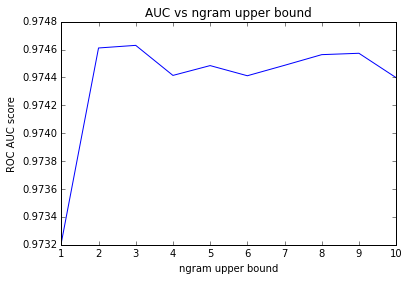

In [12]:
plt.plot(ngram_caps, aucs)
plt.title('AUC vs ngram upper bound')
plt.xlabel('ngram upper bound')
plt.ylabel('ROC AUC score')

Based on this, I cap the Ngram ceiling at 2; further improvements seem more signal than noise and don't help much. Looking at the curve for the test set.

In [13]:
model_ngram = models_ngram[2]

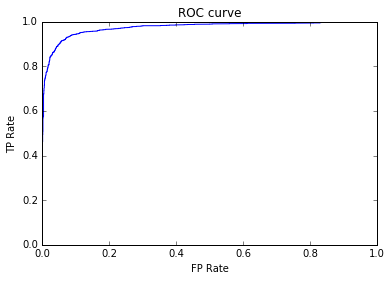

In [14]:
roc = roc_curve(y_test, model_ngram.predict_proba(X_text_test)[:,1])
plt.figure()
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

# Tweet Features

In [15]:
def modelchecks(models, modelnames, Xtr, Xte, ytr, yte):
    modelsdict = {}
    for i in range(len(models)):
        scores = cross_val_score(models[i], X_tfeats_train, y_train, cv=5, scoring = 'roc_auc')
        scoresp = str(scores)[1:-1]
        print('\n' + modelnames[i] + ':\n')
        print('Cross Val AUC scores: ' + scoresp)
        print('\nAUC Avg: ' + str(np.mean(scores)))
#         print(np.mean(scores))
        models[i].fit(Xtr, ytr)
        probs = models[i].predict_proba(Xte)
        roc = roc_curve(yte, probs[:,1])
        auc = roc_auc_score(yte, probs[:,1])
        modelsdict[modelnames[i]] = models[i]
#         print("\nAUC: " + str(auc))
        plt.figure()
        plt.plot(roc[0], roc[1])
        plt.title('ROC curve ' + modelnames[i])
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')
    return modelsdict



LogReg:

Cross Val AUC scores:  0.78279966  0.75972833  0.76456172  0.78068815  0.75823065

AUC Avg: 0.769201704163

XGBoost:

Cross Val AUC scores:  0.93068364  0.92103795  0.92695731  0.93135389  0.92738188

AUC Avg: 0.927482932891

Random Forest:

Cross Val AUC scores:  0.96501407  0.9559079   0.96023057  0.96164158  0.95998504

AUC Avg: 0.960555832004

Naive Bayes:

Cross Val AUC scores:  0.87437643  0.86163117  0.87769816  0.86220438  0.85389009

AUC Avg: 0.865960044872


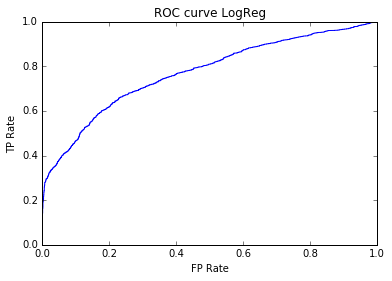

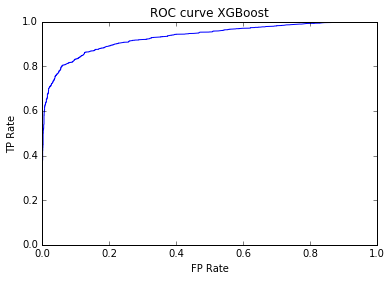

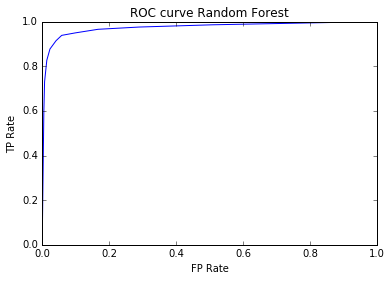

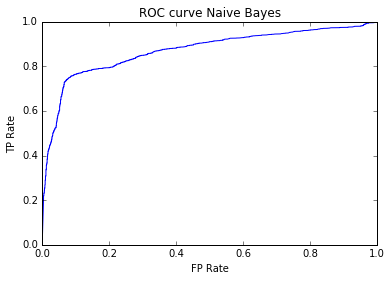

In [16]:
models_tfeats = modelchecks([LogisticRegression(), xgb(), rf(), GaussianNB()],
                             ['LogReg','XGBoost','Random Forest','Naive Bayes'],
                             X_tfeats_train,
                             X_tfeats_test,
                             y_train,
                             y_test)

Random Forest does best; using that.

In [17]:
model_tfeats = models_tfeats['Random Forest']

In [18]:
def plotimps(imps, labs, title):
    importances, labels = np.asarray(imps), np.asarray(labs)
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,5))
    plt.bar(range(len(importances)),
       importances[indices],
       color='lightblue',
       align='center')
    plt.xticks(range(len(importances)),
        labels[indices],
        rotation=90)
    plt.xlim([-1,len(importances)])
    plt.tight_layout()
    plt.ylabel('Importance')
    plt.title('FEATURE IMPORTANCES -- ' + title)
    plt.grid()
    plt.show()
    return indices

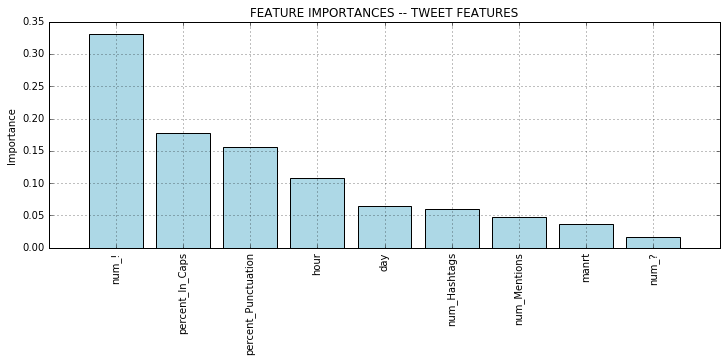

array([1, 3, 0, 7, 8, 4, 5, 6, 2])

In [19]:
plotimps(model_tfeats.feature_importances_,tfeats, 'TWEET FEATURES')

# With Reaction Features


LogReg:

Cross Val AUC scores:  0.78278652  0.75972833  0.76456266  0.78068815  0.75823065

AUC Avg: 0.769199262639

XGBoost:

Cross Val AUC scores:  0.93068364  0.92103795  0.92695731  0.93135389  0.92738188

AUC Avg: 0.927482932891

Random Forest:

Cross Val AUC scores:  0.96529721  0.95843272  0.96085711  0.96346714  0.96241973

AUC Avg: 0.962094782455

Naive Bayes:

Cross Val AUC scores:  0.87437643  0.86163117  0.87769816  0.86220438  0.85389009

AUC Avg: 0.865960044872


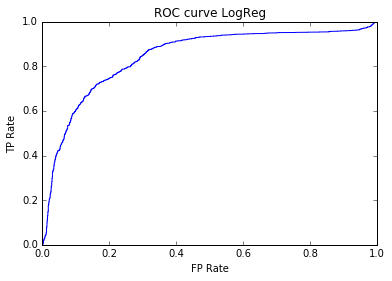

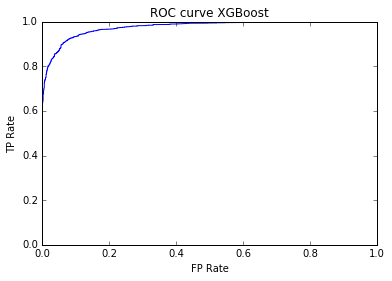

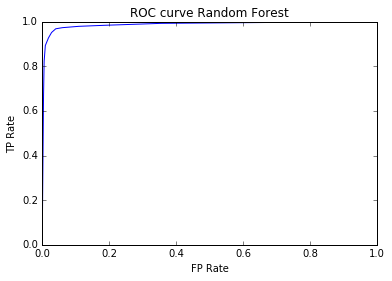

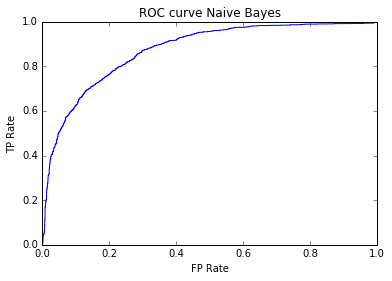

In [20]:
models_rfeats = modelchecks([LogisticRegression(), xgb(), rf(), GaussianNB()],
                             ['LogReg','XGBoost','Random Forest','Naive Bayes'],
                             X_rfeats_train,
                             X_rfeats_test,
                             y_train,
                             y_test)

These do not significantly improve predictive power, so I will leave them out.

Next I use a logistic regression to combine the two models.

AUC: 0.988923747262
Accuracy: 0.954319312528


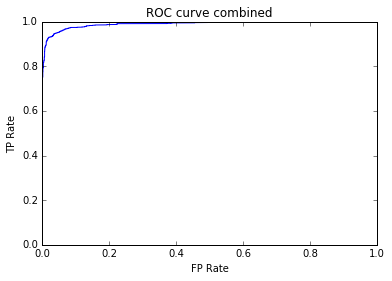

In [21]:
probstext_test = model_ngram.predict_proba(X_text_test)[:,1]
probsnt_test = model_tfeats.predict_proba(X_tfeats_test)[:,1]

probstext_train = model_ngram.predict_proba(X_text_train)[:,1]
probsnt_train = model_tfeats.predict_proba(X_tfeats_train)[:,1]



X_test2 = pd.DataFrame(data = probstext_test, columns = ['text'])
X_test2['nontext'] = probsnt_test

X_train2 = pd.DataFrame(data = probstext_train, columns = ['text'])
X_train2['nontext'] = probsnt_train

model_combined = LogisticRegression()

model_combined.fit(X_train2,y_train)
preds = model_combined.predict(X_test2)
acc = sum(preds == y_test)/len(y_test)
probs = model_combined.predict_proba(X_test2)
roc = roc_curve(y_test, probs[:,1])
auc = roc_auc_score(y_test, probs[:,1])
print("AUC: " + str(auc))
print("Accuracy: " + str(acc))
plt.figure()
plt.plot(roc[0], roc[1])
plt.title('ROC curve combined')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
